In [1]:
from transformers import (
    AutoTokenizer,
    BitsAndBytesConfig,
)

import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from Levenshtein import ratio
from msapy import msa
import pickle as pkl
import time
import re
from itertools import product

from transformers.models.mixtral.modeling_mixtral import *
from transformers.models.mixtral import *

import warnings
warnings.filterwarnings( "ignore" )

/home/shrey/miniconda3/envs/msa-xai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Initial Setup
num_permutations = 1 # Set this to 1000 to perform the full analysis. This takes a while to run. For the demonstration purpose, we set it to 1.
lesion_dictionary = defaultdict(list) # Initialize the lesion dictionary as empty meaning the network is intact
with torch.no_grad():
    torch.cuda.empty_cache()

In [3]:
device_map = "cuda:0"
model_path = "mistralai/Mixtral-8x7B-Instruct-v0.1"
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
)

In [4]:
class LesionedMixtralSparseMoeBlock(MixtralSparseMoeBlock):
    def __init__(self, config, layer_idx):
        super().__init__(config)
        self.layer_idx = layer_idx
    
    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        ## Most of the code is copied from the original implementation
        batch_size, sequence_length, hidden_dim = hidden_states.shape
        hidden_states = hidden_states.view(-1, hidden_dim)
        router_logits = self.gate(hidden_states)

        routing_weights = F.softmax(router_logits, dim=1, dtype=torch.float)
        routing_weights, selected_experts = torch.topk(routing_weights, self.top_k, dim=-1)
        routing_weights /= routing_weights.sum(dim=-1, keepdim=True)
        routing_weights = routing_weights.to(hidden_states.dtype)

        final_hidden_states = torch.zeros(
            (batch_size * sequence_length, hidden_dim), dtype=hidden_states.dtype, device=hidden_states.device
        )

        expert_mask = torch.nn.functional.one_hot(selected_experts, num_classes=self.num_experts).permute(2, 1, 0)

        for expert_idx in range(self.num_experts):
            # if the current expert is lesioned, skip it. This is the only change I made
            if expert_idx in lesion_dictionary[self.layer_idx]:
                continue 
            expert_layer = self.experts[expert_idx]
            idx, top_x = torch.where(expert_mask[expert_idx])

            if top_x.shape[0] == 0:
                continue

            top_x_list = top_x.tolist()
            idx_list = idx.tolist()

            current_state = hidden_states[None, top_x_list].reshape(-1, hidden_dim)
            current_hidden_states = expert_layer(current_state) * routing_weights[top_x_list, idx_list, None]

            final_hidden_states.index_add_(0, top_x, current_hidden_states.to(hidden_states.dtype))
        final_hidden_states = final_hidden_states.reshape(batch_size, sequence_length, hidden_dim)
        return final_hidden_states, router_logits

class LesionedMixtralDecoderLayer(MixtralDecoderLayer):
    def __init__(self, config: MixtralConfig, layer_idx: int):
        super().__init__(config, layer_idx)
        self.block_sparse_moe = LesionedMixtralSparseMoeBlock(config, layer_idx)

class LesionedMixtralModel(MixtralModel):
    def __init__(self, config: MixtralConfig):
        super().__init__(config)
        self.layers = nn.ModuleList(
            [LesionedMixtralDecoderLayer(config, layer_idx) for layer_idx in range(config.num_hidden_layers)]
        )
        self.post_init()

class LesionedMixtralForCausalLM(MixtralForCausalLM):
    _tied_weights_keys = ["lm_head.weight"]

    def __init__(self, config):
        super().__init__(config)
        self.model = LesionedMixtralModel(config)
        # Initialize weights and apply final processing
        self.post_init()

In [5]:
lesioned_model = LesionedMixtralForCausalLM.from_pretrained(
        model_path,
        device_map=device_map,
        quantization_config=quantization_config,
)

Loading checkpoint shards: 100%|██████████| 19/19 [01:49<00:00,  5.76s/it]


In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)

In [7]:
def get_addition_question(rng: np.random.Generator, size=10):
    num1_arr = rng.integers(10_000_000, size=size)
    num2_arr = rng.integers(10_000_000, size=size)
    answers = num1_arr + num2_arr
    return num1_arr, num2_arr, answers

def get_subtraction_question(rng: np.random.Generator, size=10):
    num1_arr = rng.integers(10_000_000, size=size)
    num2_arr = rng.integers(10_000_000, size=size)
    answers = num1_arr - num2_arr
    return num1_arr, num2_arr, answers

def get_multiplication_question(rng: np.random.Generator, size=10):
    num1_arr = rng.integers(10_000, size=size)
    num2_arr = rng.integers(10_000, size=size)
    answers = num1_arr * num2_arr
    return num1_arr, num2_arr, answers

In [8]:
rng = np.random.default_rng(2810)
def get_messages(num1_arr, num2_arr, answers, operation):
    messages = []
    for num1, num2 in zip(num1_arr, num2_arr):
        message = [
            {
                "role": "user",
                "content": "You are a calculator that gives answer in numbers only"
            },
            {
                "role": "assistant",
                "content": "Okay"
            },
            {
                "role": "user",
                "content": f"{num1} {operation} {num2}"
            },
        ]
        messages.append(message)

    return messages, answers

addition_messages, addition_answers = get_messages(*get_addition_question(rng), "+")
subtraction_messages, subtraction_answers = get_messages(*get_subtraction_question(rng), "-")
multiplication_messages, multiplication_answers = get_messages(*get_multiplication_question(rng), "*")

In [9]:
all_messages = addition_messages + subtraction_messages + multiplication_messages
all_answers = np.concatenate([addition_answers, subtraction_answers, multiplication_answers])

all_messages = [tokenizer.apply_chat_template(message, tokenize=False) for message in all_messages]
tokenizer.pad_token = tokenizer.eos_token
inputs = tokenizer(all_messages, return_tensors="pt", padding=True).to(device_map)

In [10]:
def extract_answer(output: str):
    number_pattern = re.compile(r'\[\/INST\][^\[]*?(-?\d[\d,\.]*)')
    number = number_pattern.findall(output)[-1].replace(',', '')
    if '.' in number:
        number = str(int(float(number)))
    return number

def get_accuracy(output: str, real_answer: int):
    try:
        return ratio(extract_answer(output), str(real_answer))
    except:
        return 0

def get_operation_wise_accuracy(outputs: list[str], answers: np.ndarray) -> np.ndarray:
    return np.array([get_accuracy(output, answer) for output, answer in zip(outputs, answers)]).reshape(3, -1).mean(axis=1) 

In [11]:
def complements_to_lesion_dict(coplements):
    global lesion_dictionary
    lesion_dictionary = defaultdict(list)
    for c in coplements:
        lesion_dictionary[c[0]].append(c[1])

In [12]:
@torch.no_grad()
def objective_function(coplements):
    global lesion_dictionary
    complements_to_lesion_dict(coplements)
    outputs = lesioned_model.generate(**inputs, max_new_tokens=10, pad_token_id = tokenizer.eos_token_id)
    outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return get_operation_wise_accuracy(outputs, all_answers)

In [13]:
# Unlesioned accuracy of the model on all tasks
unlesioned_addition_accuracy, unlesioned_subtraction_accuracy, unlesioned_multiplication_accuracy = objective_function([])

print(f"Unlesioned accuracy of the model on addition task: {unlesioned_addition_accuracy}")
print(f"Unlesioned accuracy of the model on subtraction task: {unlesioned_subtraction_accuracy}")
print(f"Unlesioned accuracy of the model on multiplication task: {unlesioned_multiplication_accuracy}")

Unlesioned accuracy of the model on addition task: 0.9625
Unlesioned accuracy of the model on subtraction task: 0.9571428571428571
Unlesioned accuracy of the model on multiplication task: 0.5159173669467787


In [14]:
elements = list(product(list(range(32)), list(range(8))))

In [ ]:
shapley_table = msa.interface(
    n_permutations=num_permutations,
    elements=elements,
    objective_function=objective_function,
)

In [15]:
# Uncomment the following code to save your computed results
# saving_dict = {
#     "shapley_table": shapley_table,
#     "messages": all_messages,
#     "answers": all_answers,
# }

# with open(f"shapley_analysis_mixtral_llm_{time.strftime('%Y%m%d-%H%M%S')}.pkl", "wb") as f:
#     pkl.dump(saving_dict, f)

In [16]:
# We will be using already computed results to speed up the notebook
with open("pickled_results/shapley_analysis_mixtral_llm_20240317-083013.pkl", "rb") as f:
    shapley_results = pkl.load(f)

shapley_table = shapley_results["shapley_table"]

In [17]:
shapley_table.columns = shapley_table.columns.astype(str)
shapley_df_formatted = pd.DataFrame(shapley_table).melt(ignore_index=False, var_name="Layer_Expert", value_name="Contribution")
task_mapping = {0: "Addition", 1: "Subtraction", 2: "Multiplication"}
shapley_df_formatted['Task'] = shapley_df_formatted.index.map(task_mapping)
shapley_df_formatted['Layer'], shapley_df_formatted['Expert'] = zip(*shapley_df_formatted['Layer_Expert'].apply(eval))
shapley_df_formatted.drop(columns=["Layer_Expert"], inplace=True)
shapley_df_formatted.to_csv("shapley_analysis.csv")
shapley_df_formatted.head()

,Contribution,Task,Layer,Expert
0,0.000186,Addition,0,0
1,-0.001046,Subtraction,0,0
2,-0.001478,Multiplication,0,0
0,0.027317,Addition,0,1
1,0.028780,Subtraction,0,1


Text(0.5, 1.0, 'Layer and Task wise contribution')

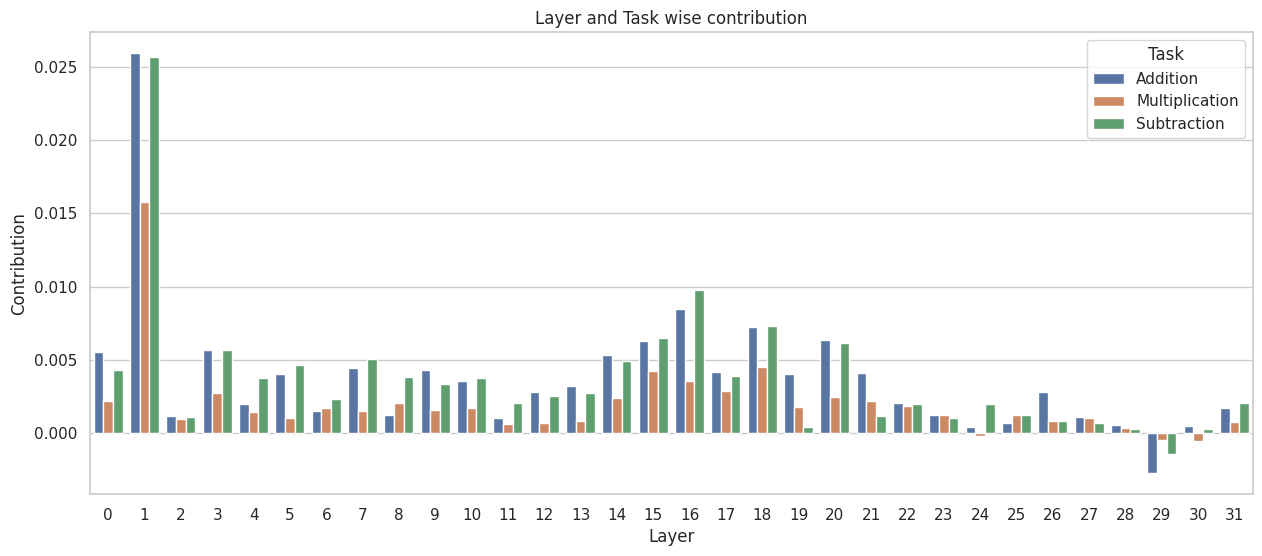

In [18]:
layer_and_task_wise_contributions = shapley_df_formatted.groupby(["Layer", "Task"])["Contribution"].mean().reset_index()

plt.figure(figsize=(15, 6))
sns.set_theme(style="whitegrid")
sns.barplot(data=layer_and_task_wise_contributions, x="Layer", y="Contribution", hue="Task")
plt.title("Layer and Task wise contribution")

Text(0.5, 1.0, 'Expert and Task wise contribution of Layer 1')

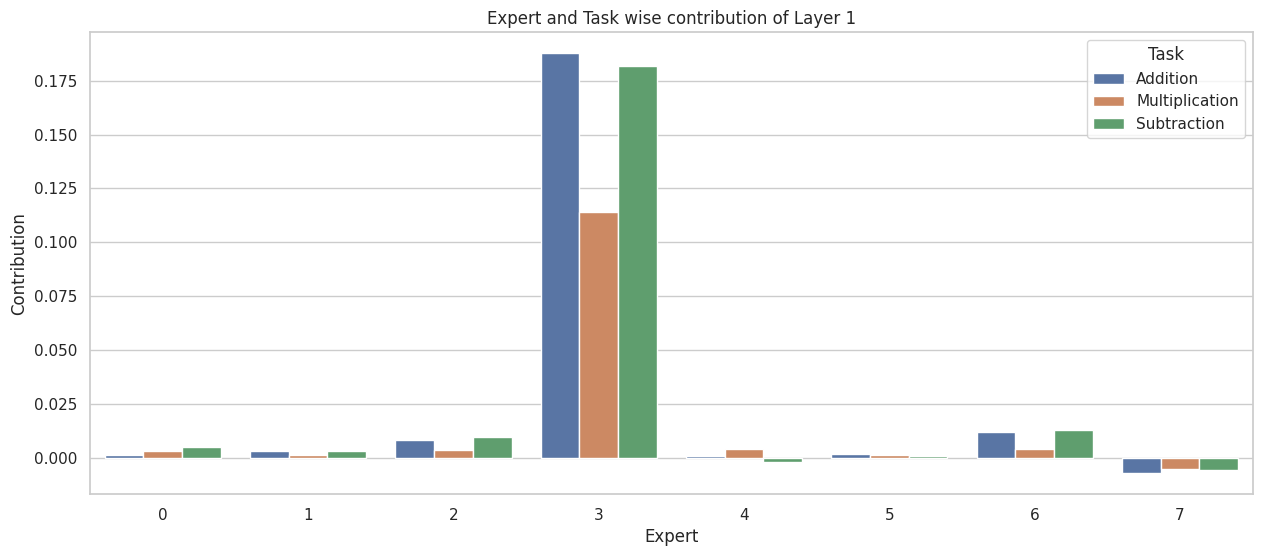

In [19]:
# Plot Expert Contribution of Layer 1
expert_and_task_wise_contributions = shapley_df_formatted[shapley_df_formatted["Layer"] == 1].groupby(["Expert", "Task"])["Contribution"].mean().reset_index()

plt.figure(figsize=(15, 6))
sns.set_theme(style="whitegrid")
sns.barplot(data=expert_and_task_wise_contributions, x="Expert", y="Contribution", hue="Task")
plt.title("Expert and Task wise contribution of Layer 1")

Text(0.5, 1.0, 'Expert and Task wise contribution of Layer 1')

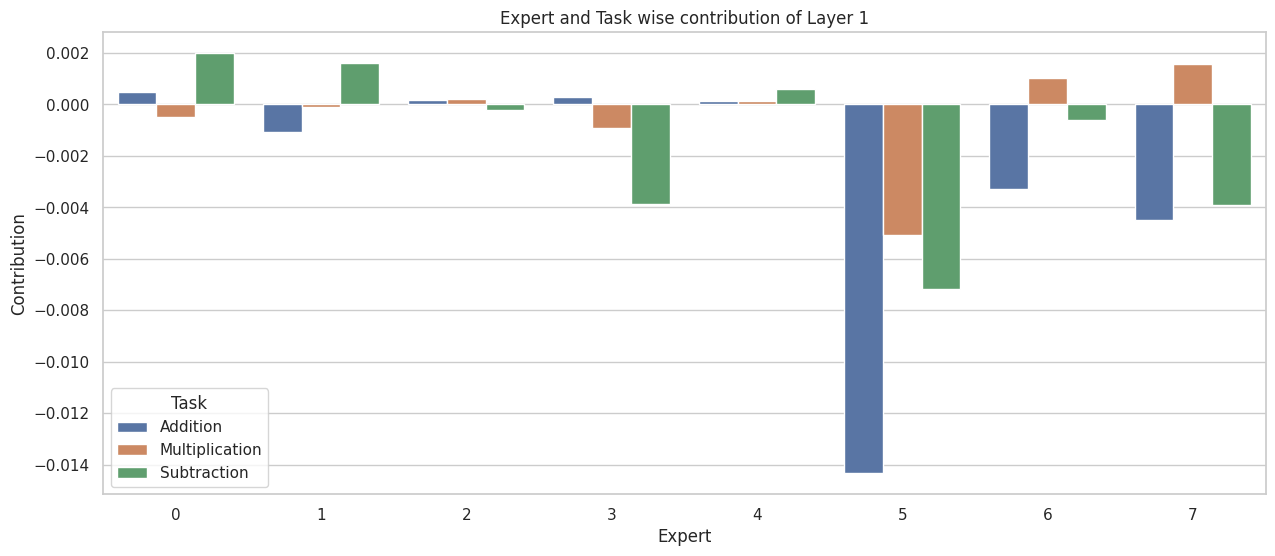

In [20]:
# Plot Expert Contribution of Layer 1
expert_and_task_wise_contributions = shapley_df_formatted[shapley_df_formatted["Layer"] == 29].groupby(["Expert", "Task"])["Contribution"].mean().reset_index()

plt.figure(figsize=(15, 6))
sns.set_theme(style="whitegrid")
sns.barplot(data=expert_and_task_wise_contributions, x="Expert", y="Contribution", hue="Task")
plt.title("Expert and Task wise contribution of Layer 1")

In [21]:
# Creating a test set
rng = np.random.default_rng(1207)

addition_messages, addition_answers = get_messages(*get_addition_question(rng, size=50), "+")
subtraction_messages, subtraction_answers = get_messages(*get_subtraction_question(rng, size=50), "-")
multiplication_messages, multiplication_answers = get_messages(*get_multiplication_question(rng, size=50), "*")

all_messages = addition_messages + subtraction_messages + multiplication_messages
all_answers = np.concatenate([addition_answers, subtraction_answers, multiplication_answers])
all_messages = [tokenizer.apply_chat_template(message, tokenize=False) for message in all_messages]
tokenizer.pad_token = tokenizer.eos_token
inputs = tokenizer(all_messages, return_tensors="pt", padding=True).to(device_map)

unlesioned_addition_accuracy, unlesioned_subtraction_accuracy, unlesioned_multiplication_accuracy = objective_function([])

print(f"Unlesioned accuracy of the model on addition task: {unlesioned_addition_accuracy}")
print(f"Unlesioned accuracy of the model on subtraction task: {unlesioned_subtraction_accuracy}")
print(f"Unlesioned accuracy of the model on multiplication task: {unlesioned_multiplication_accuracy}")

Unlesioned accuracy of the model on addition task: 0.9358809523809524
Unlesioned accuracy of the model on subtraction task: 0.9307142857142858
Unlesioned accuracy of the model on multiplication task: 0.557999066293184


In [22]:
def print_lesioning_accuracy_results(complements):
    lesioned_addition_accuracy, lesioned_subtraction_accuracy, lesioned_multiplication_accuracy = objective_function(complements)

    print(f"Number of experts lesioned: {len(complements)}")
    print(f"addition accuracy {'increased' if lesioned_addition_accuracy > unlesioned_addition_accuracy else 'decreased'} by {abs(lesioned_addition_accuracy - unlesioned_addition_accuracy):.4f} after leasioning")
    print(f"subtraction accuracy {'increased' if lesioned_subtraction_accuracy > unlesioned_subtraction_accuracy else 'decreased'} by {abs(lesioned_subtraction_accuracy - unlesioned_subtraction_accuracy):.4f} after leasioning")
    print(f"multiplication accuracy {'increased' if lesioned_multiplication_accuracy > unlesioned_multiplication_accuracy else 'decreased'} by {abs(lesioned_multiplication_accuracy - unlesioned_multiplication_accuracy):.4f} after leasioning")

In [23]:
# Since expert 3 of layer 1 is highly contributing to the all tasks, lets see the affect on the lesioning
complements = [(1, 3)]
print_lesioning_accuracy_results(complements)

Number of experts lesioned: 1
addition accuracy decreased by 0.1171 after leasioning
subtraction accuracy decreased by 0.0742 after leasioning
multiplication accuracy decreased by 0.0238 after leasioning


In [24]:
# Now lets see the difference in lesioning for the top 5 highest contributing experts with positive contributions for all tasks
mask_all_positive_contributors = shapley_df_formatted.groupby(["Layer", "Expert"])["Contribution"].min().reset_index()["Contribution"] > 0
all_positive_contributors = shapley_df_formatted.groupby(["Layer", "Expert"])["Contribution"].mean().reset_index()[mask_all_positive_contributors].sort_values(by="Contribution", ascending=False)
all_positive_contributors.head()

,Layer,Expert,Contribution
11,1,3,0.161232
145,18,1,0.033459
122,15,2,0.023884
166,20,6,0.023560
131,16,3,0.022821


In [25]:
layer_expert_tuple_positive_contributors = list(zip(all_positive_contributors["Layer"], all_positive_contributors["Expert"]))
print_lesioning_accuracy_results(layer_expert_tuple_positive_contributors[:5])

Number of experts lesioned: 5
addition accuracy decreased by 0.4564 after leasioning
subtraction accuracy decreased by 0.4610 after leasioning
multiplication accuracy decreased by 0.2437 after leasioning


In [26]:
# Now lets see the difference in lesioning for the top 50 lowest contributing experts with negative contributions for all tasks
mask_all_negative_contributors = shapley_df_formatted.groupby(["Layer", "Expert"])["Contribution"].max().reset_index()["Contribution"] < 0
all_negative_contributors = shapley_df_formatted.groupby(["Layer", "Expert"])["Contribution"].mean().reset_index()[mask_all_negative_contributors].sort_values(by="Contribution", ascending=True)
all_negative_contributors.head()

,Layer,Expert,Contribution
237,29,5,-0.008866
5,0,5,-0.008293
15,1,7,-0.006141
240,30,0,-0.004205
54,6,6,-0.003897


In [27]:
layer_expert_tuple_negative_contributors = list(zip(all_negative_contributors["Layer"], all_negative_contributors["Expert"]))
print_lesioning_accuracy_results(layer_expert_tuple_negative_contributors)

Number of experts lesioned: 19
addition accuracy increased by 0.0105 after leasioning
subtraction accuracy decreased by 0.0089 after leasioning
multiplication accuracy increased by 0.0172 after leasioning


In [28]:
# Focusing only on the multiplication task, lets try to increase it accuracy by removing negatively contributing experts
task = "Multiplication"
negative_contributors_multiplication = shapley_df_formatted[(shapley_df_formatted["Task"] == task) & (shapley_df_formatted["Contribution"] < 0)].sort_values(by="Contribution", ascending=True)
layer_expert_tuple_negative_contributors_multiplication = list(zip(negative_contributors_multiplication["Layer"], negative_contributors_multiplication["Expert"]))
print_lesioning_accuracy_results(layer_expert_tuple_negative_contributors_multiplication[:25])  

Number of experts lesioned: 25
addition accuracy decreased by 0.0041 after leasioning
subtraction accuracy decreased by 0.0115 after leasioning
multiplication accuracy increased by 0.0324 after leasioning


In [29]:
(5.6 - 3) / 5.6

0.46428571428571425

In [30]:
task = "Addition"
negative_contributors_addition = shapley_df_formatted[(shapley_df_formatted["Task"] == task) & (shapley_df_formatted["Contribution"] < 0)].sort_values(by="Contribution", ascending=True)
layer_expert_tuple_negative_contributors_addition = list(zip(negative_contributors_addition["Layer"], negative_contributors_addition["Expert"]))
print_lesioning_accuracy_results(layer_expert_tuple_negative_contributors_addition)

Number of experts lesioned: 61
addition accuracy increased by 0.0105 after leasioning
subtraction accuracy decreased by 0.0370 after leasioning
multiplication accuracy decreased by 0.0026 after leasioning


In [31]:
task = "Subtraction"
negative_contributors_subtraction = shapley_df_formatted[(shapley_df_formatted["Task"] == task) & (shapley_df_formatted["Contribution"] < 0)].sort_values(by="Contribution", ascending=True)
layer_expert_tuple_negative_contributors_subtraction = list(zip(negative_contributors_subtraction["Layer"], negative_contributors_subtraction["Expert"]))
print_lesioning_accuracy_results(layer_expert_tuple_negative_contributors_subtraction[:5])

Number of experts lesioned: 5
addition accuracy increased by 0.0092 after leasioning
subtraction accuracy increased by 0.0051 after leasioning
multiplication accuracy decreased by 0.0053 after leasioning


In [32]:
countries_population_task_message = [
    {
        "role": "user",
        "content": "Tell me the top 10 most populated countries as a list. Be Concise"
    }
]
countries_population_task_message = tokenizer.apply_chat_template(countries_population_task_message, return_tensors="pt", padding=True)

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.


In [33]:
complements_to_lesion_dict(layer_expert_tuple_negative_contributors)
lesioned_output_poplation_task = lesioned_model.generate(countries_population_task_message, max_new_tokens=50, pad_token_id = tokenizer.eos_token_id)
lesioned_output_poplation_task = tokenizer.batch_decode(lesioned_output_poplation_task, skip_special_tokens=True)
print(lesioned_output_poplation_task[0])

[INST] Tell me the top 10 most populated countries as a list. Be Concise [/INST] Sure, here are the top 10 most populated countries in the world as of 2021:

1. China
2. India
3. United States
4. Indonesia
5. Pakistan
6. Brazil


In [34]:
# Now Unlesioned
complements_to_lesion_dict([])
unlesioned_output_poplation_task = lesioned_model.generate(countries_population_task_message, max_new_tokens=50, pad_token_id = tokenizer.eos_token_id)
unlesioned_output_poplation_task = tokenizer.batch_decode(unlesioned_output_poplation_task, skip_special_tokens=True)
print(unlesioned_output_poplation_task[0])

[INST] Tell me the top 10 most populated countries as a list. Be Concise [/INST] Sure, here is a list of the 10 most populated countries in the world as of 2021, ranked in descending order:

1. China
2. India
3. United States
4. Indonesia


In [35]:
# 3x3 Matrix of all Tasks explaining what happens when we lesion top and bottom n experts